### Preliminaries

In [44]:
# Imports

#import gymnasium as gym
import importlib
import environment
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
import sys
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Re-import environment when modified
importlib.reload(environment)

<module 'environment' from '/Users/paulsalquebre/Documents/SkyjoRL/environment.py'>

In [19]:
# A function to print the current board state

def print_board(state):
    """Print the board as described by the state"""
    player_turn = state["player_turn"]
    players_deck_i_values = state["player_deck_i_values"]
    players_deck_i_mask = state["player_deck_i_mask"]
    visible_card_value = state["visible_card_value"]
    done = state["done"]
    n_players = len(players_deck_i_values)

    if done:
        print("The game has ended!")
        for p in range(n_players):
            print(f"Player {p} has a score of {np.sum(players_deck_i_values[p])}")
    else:
        # Print player turn
        if player_turn[1] == 0:
            #print(f"Player {player_turn[0]} needs to draw a card.")
            print(f"Visible card: {visible_card_value}\n")
        else:
            #print(f"Player {player_turn[0]} has drawn the card {visible_card_value} from the draw pile or the visible card.\n")
            print(f"Card drawn: {visible_card_value}\n")

    # Print each player's deck
    for p in range(n_players):
        player_deck_values = players_deck_i_values[p]
        player_deck_mask = players_deck_i_mask[p]
        print(f"----- PLAYER {p} -----")
        for i in range(player_deck_values.shape[0]):
            row = "|"
            for j in range(player_deck_values.shape[1]):
                if player_deck_mask[i,j] == 1:
                    row += f"  {player_deck_values[i,j]:02}"
                else:
                    row += "  **"
            row += "  |"
            print(row)
        print("--------------------")
        print("")

In [20]:
# set up matplotlib

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [21]:
# Device

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print("Device:", device)
device = torch.device("cpu")

Device: mps


### Deep-Q-Network

##### Agent design

In [33]:
# Replay memory

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [34]:
# Network

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [35]:
# Encoding the observation

def one_hot_encoding_obs(obs, device):
    m, n = 3, 4
    encoded_obs = torch.zeros((16 * m * n + 16 + 1), device=device, dtype=torch.float32)

    deck_values = obs["deck_values"].copy()
    deck_mask = obs["deck_mask"].copy()
    visible_card = obs["visible_card"]
    is_first_action = obs["player_turn"][1]

    # One-hot-encoding of each player's deck cards
    for i in range(m):
        for j in range(n):
            position_id = 16*(i*n + j)
            if deck_mask[i,j] == 0: # Invisible card
                encoded_obs[position_id + 15] = 1
            else:
                value = deck_values[i,j]
                encoded_obs[position_id + value + 2] = 1 # The plus is because the value starts from -2

    # One-hot-encoding of the visible card
    encoded_obs[16*m*n + visible_card + 2] = 1

    # Encode if this is the player's first action (0) or second (1)
    encoded_obs[16*m*n + 16] = is_first_action

    return encoded_obs

# We use the name encode_obs during training
def encode_obs(obs, device):
    return one_hot_encoding_obs(obs, device)

In [36]:
# Actions encoding and decoding

# [ 0,-1,-1,-1]  -> 0
# [ 1,-1,-1,-1]  -> 1
# [-1, 0, i, j]  -> 2 + i*4 + j
# [-1, 1, i, j]  -> 2 + 12 + i*4 + j


def encode_actions_np(actions):
    m, n = 3, 4
    is_first_move = np.where(actions[:,0] > -1, 1, 0)
    actions_encoded = is_first_move * actions[:,0]  + (1 - is_first_move) * (2 + (actions[:,1]*n*m + actions[:,2]*n + actions[:,3]))
    return actions_encoded

def encode_actions_torch(actions):
    m, n = 3, 4
    is_first_move = torch.where(actions[:, 0] > -1, torch.tensor(1, device=actions.device), torch.tensor(0, device=actions.device))
    actions_encoded = is_first_move * actions[:, 0] + (1 - is_first_move) * (2 + (actions[:, 1] * n * m + actions[:, 2] * n + actions[:, 3]))
    return actions_encoded


def decode_actions_np(actions_encoded):
    m, n = 3, 4
    actions = -np.ones((len(actions_encoded), 4))
    first_move_actions = (actions_encoded < 2)
    actions[first_move_actions,0] = actions_encoded[first_move_actions]
    actions_1 = (actions_encoded - 2) // (n * m)
    actions_2 = ((actions_encoded - 2) % (n * m)) // n
    actions_3 = ((actions_encoded - 2) % (n * m)) % n
    actions[~first_move_actions,1] = actions_1[~first_move_actions]
    actions[~first_move_actions,2] = actions_2[~first_move_actions]
    actions[~first_move_actions,3] = actions_3[~first_move_actions]
    return actions

def decode_actions_torch(actions_encoded):
    m, n = 3, 4
    actions = -torch.ones((len(actions_encoded), 4), dtype=torch.long, device=actions_encoded.device)
    first_move_actions = actions_encoded < 2
    actions[first_move_actions, 0] = actions_encoded[first_move_actions]
    actions_1 = (actions_encoded - 2) // (n * m)
    actions_2 = ((actions_encoded - 2) % (n * m)) // n
    actions_3 = ((actions_encoded - 2) % (n * m)) % n
    actions[~first_move_actions, 1] = actions_1[~first_move_actions]
    actions[~first_move_actions, 2] = actions_2[~first_move_actions]
    actions[~first_move_actions, 3] = actions_3[~first_move_actions]
    return actions

In [37]:
# Select an action, according to the Q-network

def select_action(obs, network, valid_actions, epsilon, device):
    if random.random() < epsilon:
        return random.choice(valid_actions).to(device)
    else:
        with torch.no_grad():
            obs_encoded = encode_obs(obs, device)
            q_values = network(obs_encoded)
            valid_actions_encoded = encode_actions_torch(torch.stack(valid_actions))
            invalid_actions_mask = torch.ones_like(q_values, device=device, dtype=bool)
            invalid_actions_mask[valid_actions_encoded] = False
            q_values_valid = q_values.masked_fill(invalid_actions_mask, float('-inf'))
            best_action_encoded = q_values_valid.argmax()
            action = decode_actions_torch(best_action_encoded.unsqueeze(0)).squeeze(0)
        return action

##### Training

In [38]:
# Training initialization

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 8
GAMMA = 0.99
#EPS_START = 0.9
#EPS_END = 0.05
#EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

env = environment.SkyjoEnv(n_players=1)
obs = env.reset()
# Get number of actions from gym action space
n_actions = 2 + 2 * env.grid_size[0] * env.grid_size[1]
# Get the number of state observations
n_observations = len(encode_obs(obs, device))

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

memory = ReplayMemory(10000)
num_episodes = 1000

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

In [39]:
# Optimization step function

def optimize_model(memory, policy_net, target_net, device):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch.view(1,-1))

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(0))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [40]:
# Training function

def train_model(policy_net, target_net, memory, num_episodes, device):
    env = environment.SkyjoEnv(n_players=1)
    steps_done = 0
    sum_rewards = []
    epsilon = 1
    eps_decay = 0.997
    for i_episode in range(num_episodes):
        steps_done += 1
        round_count = 0
        max_num_rounds = 50
        if i_episode % 1 == 0:
            print("\rEpisode {}/{}. (eps={:.2f})".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()
        epsilon = max(0.05, epsilon*eps_decay)
        
        # Initialize the environment and get its state
        obs = env.reset()
        obs_encoded = encode_obs(obs, device).unsqueeze(0)
        for t in count():
            round_count += 1
            valid_actions = env.get_valid_actions()
            action = select_action(obs, policy_net, valid_actions, epsilon, device)
            action_encoded = encode_actions_torch(action.unsqueeze(0))
            next_obs, reward, terminated = env.step(action)
            next_obs_encoded = encode_obs(next_obs, device).unsqueeze(0)
            reward = torch.tensor([reward], device=device, dtype=torch.float32)
            done = terminated

            if terminated:
                next_obs_encoded = None

            # Store the transition in memory
            memory.push(obs_encoded, action_encoded, next_obs_encoded, reward)

            # Move to the next state
            obs = next_obs
            obs_encoded = next_obs_encoded

            # Perform one step of the optimization (on the policy network)
            optimize_model(memory, policy_net, target_net, device)

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done or round_count == max_num_rounds:
                sum_rewards.append(env.get_sum_cards(next_obs["deck_values"], np.ones((3,4), dtype=bool)))
                break

    print('\nComplete')
    return sum_rewards

In [42]:
# Train

sum_rewards = train_model(policy_net, target_net, memory, num_episodes, device)

Episode 999/1000. (eps=0.05)
Complete


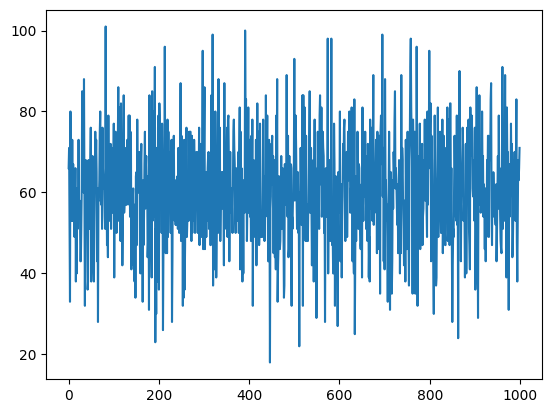

In [43]:
# Plot rewards during training

plt.plot(sum_rewards)
plt.show()

### Test

In [ ]:
# A singleplayer game, with the baseline agent

env = environment.SkyjoEnv(n_players=1)
observation = env.reset()

done = False

while not done:
    print_board(env.get_state())
    valid_actions = env.get_valid_actions()
    action = select_action(observation, policy_net, valid_actions, 0, device)
    if action[0] == 0:
        print(f"The player draws from the pile")
    else:
        print(f"The player draws the visible card")
    observation, _, _ = env.step(action)

    valid_actions = env.get_valid_actions()
    action = select_action(observation, policy_net, valid_actions, 0, device)
    print(f"The player has drawn the card: {observation["visible_card"]}")
    if action[1] == 1:
        print(f"The player use the drawn card and put it in the position {action[2]},{action[3]}")
    else:
        print(f"The player discards the drawn card and uncover the card in the position {action[2]},{action[3]}")
    observation, reward, done = env.step(action)
    print("\n##########################################\n")
    time.sleep(1)

print_board(env.get_state())

Visible card: 8

----- PLAYER 0 -----
|  05  11  **  **  |
|  **  **  **  **  |
|  **  **  **  **  |
--------------------

The player draws the visible card
The player has drawn the card: 8
The player discards the drawn card and uncover the card in the position 2,0

##########################################

Visible card: 8

----- PLAYER 0 -----
|  05  11  **  **  |
|  **  **  **  **  |
|  02  **  **  **  |
--------------------

The player draws the visible card
The player has drawn the card: 8
The player discards the drawn card and uncover the card in the position 2,1

##########################################

Visible card: 8

----- PLAYER 0 -----
|  05  11  **  **  |
|  **  **  **  **  |
|  02  07  **  **  |
--------------------

The player draws the visible card
The player has drawn the card: 8
The player use the drawn card and put it in the position 1,0

##########################################

Visible card: 9

----- PLAYER 0 -----
|  05  11  **  **  |
|  08  **  **  **  |
| 

KeyboardInterrupt: 